# Library

In [183]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# GPU 용량 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# FI_mean_merge
- feature별 base_pred, 1to0_pred, 0to1_pred, inverse_pred의 각각 평균이 담긴 df 생성

## df 3개로 저장

In [21]:
# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# 3) 평균예측값 baseline (Y')
pred = lstm2.predict(X_test)
pred_value = np.mean(pred)

In [30]:
# 4) 0 to 1
total_data = pd.read_csv('total_data_7727.csv')
features = total_data['ITEMID'].sort_values().unique()
results = []
results.append({'feature':'baseline',
                'pred_mean':pred_value})

for i in tqdm(range(len(features))):
    save_col = X_test[:,:,i].copy()
    X_test[:,:,i] = np.where(X_test[:,:,i]==0, 1, X_test[:,:,i])

    preds = lstm2.predict(X_test)
    results.append({'feature':features[i],
                    'pred_mean':np.mean(preds)})
    X_test[:,:,i] = save_col
    
df = pd.DataFrame(results)
df
# df.to_csv('./17_df/0to1_df.csv',index=False)

100%|██████████| 4068/4068 [30:55<00:00,  2.19it/s]


,feature,pred_mean
0,baseline,0.636932
1,0,0.602555
2,50803,0.596538
3,50804,0.656048
4,50805,0.588659
...,...,...
4064,78112001103,0.572699
4065,79511050204,0.620735
4066,87701071218,0.713154
4067,87701083336,0.630232


In [31]:
# 5) 1 to 0
results = []
results.append({'feature':'baseline',
                'pred_mean_1to0':pred_value})

for i in tqdm(range(len(features))):
    save_col = X_test[:,:,i].copy()
    X_test[:,:,i] = np.where(X_test[:,:,i]==1, 0, X_test[:,:,i])

    preds = lstm2.predict(X_test)
    results.append({'feature':features[i],
                    'pred_mean_1to0':np.mean(preds)})
    X_test[:,:,i] = save_col
    
df2 = pd.DataFrame(results)
df2
# df2.to_csv('./17_df/1to0_df.csv',index=False)

100%|██████████| 4068/4068 [32:15<00:00,  2.10it/s]


,feature,pred_mean_1to0
0,baseline,0.636932
1,0,0.664229
2,50803,0.622951
3,50804,0.620827
4,50805,0.622909
...,...,...
4064,78112001103,0.623312
4065,79511050204,0.622900
4066,87701071218,0.622032
4067,87701083336,0.622898


In [ ]:
# 6) inverse
results = []
results.append({'feature':'baseline',
                'pred_mean_inverse':pred_value})

for i in tqdm(range(len(features))):
    save_col = X_test[:,:,i].copy()

    X_test[:,:,i] = np.where(X_test[:,:,i]==1, 2, X_test[:,:,i])
    X_test[:,:,i] = np.where(X_test[:,:,i]==0, 1, X_test[:,:,i])
    X_test[:,:,i] = np.where(X_test[:,:,i]==2, 0, X_test[:,:,i])

    preds = lstm2.predict(X_test)
    results.append({'feature':features[i],
                    'pred_mean_inverse':np.mean(preds)})
    X_test[:,:,i] = save_col
        
df3 = pd.DataFrame(results)
df3
# df3.to_csv('./17_df/pred_inverse.csv', index=False)

## merge

In [2]:
df_0to1 = pd.read_csv('./17_df/0to1_df.csv')
df_1to0 = pd.read_csv('./17_df/1to0_df.csv')
df_inverse = pd.read_csv('./17_df/pred_inverse.csv')

In [5]:
FI_mean_merge = df_0to1.copy()
FI_mean_merge = pd.merge(FI_mean_merge,df_1to0,on='feature')
FI_mean_merge = pd.merge(FI_mean_merge,df_inverse,on='feature')
FI_mean_merge.columns = ['feature','pred_0to1','pred_1to0','pred_inverse']
FI_mean_merge['baseline'] = FI_mean_merge.iloc[0,1]
FI_mean_merge = FI_mean_merge.drop([0])
FI_mean_merge
# FI_mean_merge.to_csv('FI_mean_merge.csv',index=False)

,feature,pred_0to1,pred_1to0,pred_inverse,baseline
1,0,0.602555,0.664229,0.658366,0.636932
2,50803,0.596538,0.622951,0.610879,0.636932
3,50804,0.656048,0.620827,0.667633,0.636932
4,50805,0.588659,0.622909,0.603060,0.636932
5,50806,0.672240,0.622698,0.685195,0.636932
...,...,...,...,...,...
4064,78112001103,0.572699,0.623312,0.587544,0.636932
4065,79511050204,0.620735,0.622900,0.634779,0.636932
4066,87701071218,0.713154,0.622032,0.724196,0.636932
4067,87701083336,0.630232,0.622898,0.644181,0.636932


# FI_merge 시각화 함수
- FI 종류 : inverse, 0to1, 1to0
- 특정 itemid에 대한 7727명의 4종류 pred_value를 구해서 violin plot으로 시각화

In [189]:
# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
    # 2) MODEL
    from keras.models import load_model
    lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

In [190]:
def FI_merge(itemid):
    # for문 돌릴 때 X_test 복원용 
    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    # 3) 환자별 base pred (Y')
    base_pred = pd.DataFrame(lstm2.predict(X_test))
    
    total_data = pd.read_csv('total_data_7727.csv')
    features = total_data['ITEMID'].sort_values().unique()

    k = list(features).index(itemid)
    save_col = X_test[:,:,k].copy()

    # 4) 0 to 1
    X_test[:,:,k]= np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
    pred_0to1 = pd.DataFrame(lstm2.predict(X_test))

    # 5) 1 to 0
    X_test[:,:,k] = np.where(X_test[:,:,k]==1, 0, X_test[:,:,k])
    pred_1to0 = pd.DataFrame(lstm2.predict(X_test))

    # 6) inverse
    X_test[:,:,k] = save_col
    X_test[:,:,k] = np.where(X_test[:,:,k]==1, 2, X_test[:,:,k])
    X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
    X_test[:,:,k] = np.where(X_test[:,:,k]==2, 0, X_test[:,:,k])
    pred_inverse = pd.DataFrame(lstm2.predict(X_test))

    # 7) Merge & Visualize
    FI_merge_df = pd.concat([base_pred, pred_0to1, pred_1to0, pred_inverse], axis=1)
    FI_merge_df.columns = ['base_pred', 'pred_0to1', 'pred_1to0', 'pred_inverse']
    FI_merge_visual = FI_merge_df.melt(value_vars=['base_pred','pred_0to1','pred_1to0','pred_inverse'])
    FI_merge_visual.columns = ['method','pred_value']
    
    ax = plt.figure(figsize=(7,5),dpi=100)
    ax = sns.violinplot(data=FI_merge_visual, x='method',y='pred_value',
                        palette="Set2", inner="quartile")
    _ = plt.title(itemid)

## RF top10

100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


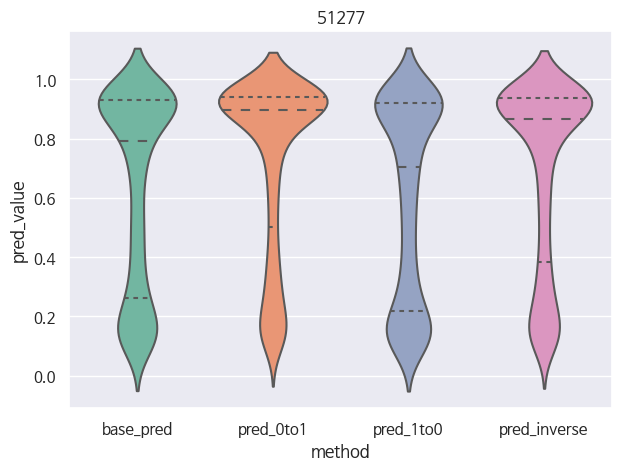

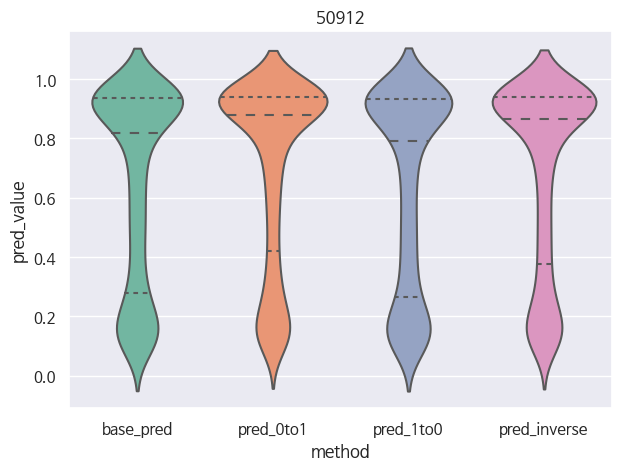

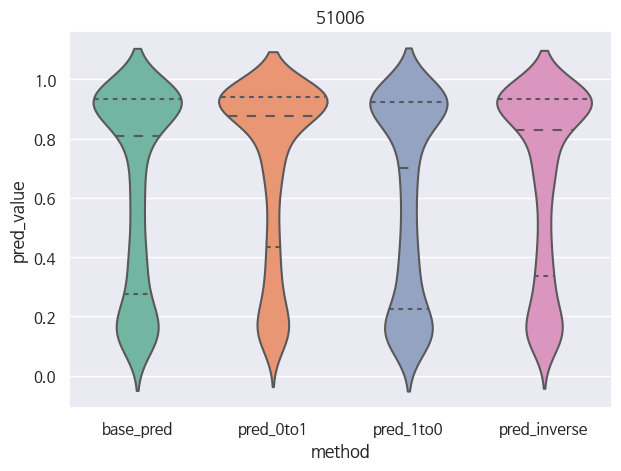

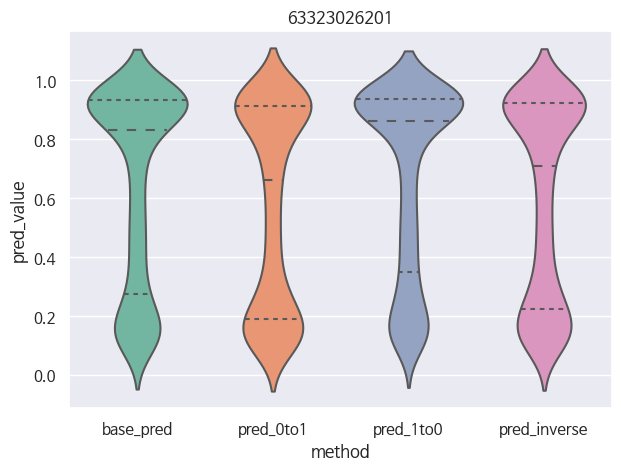

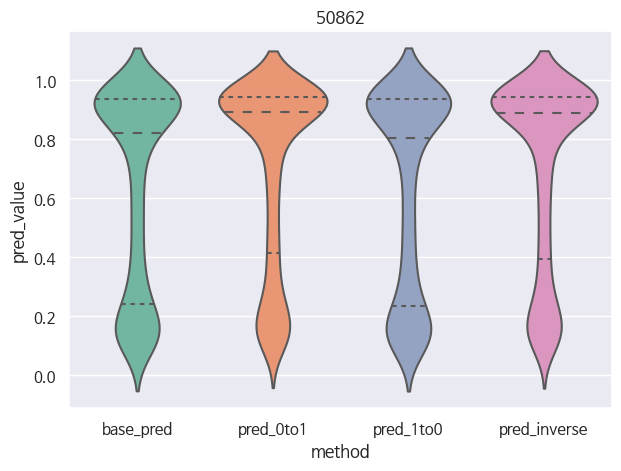

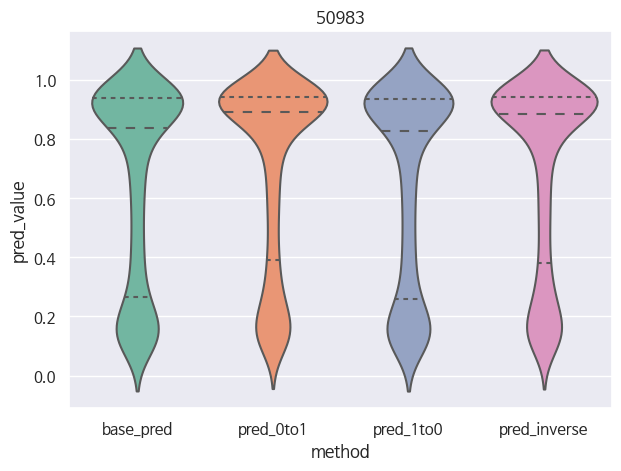

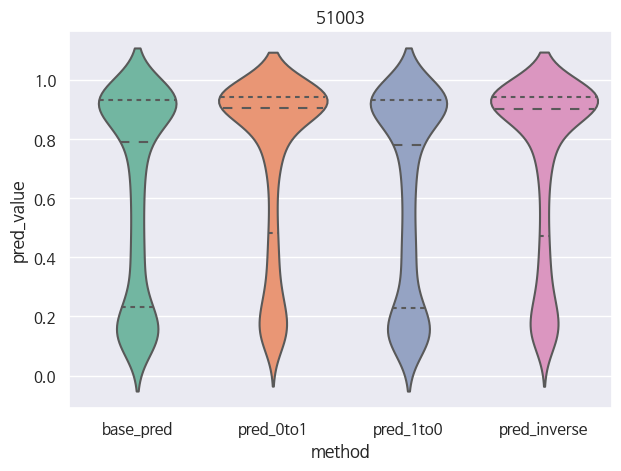

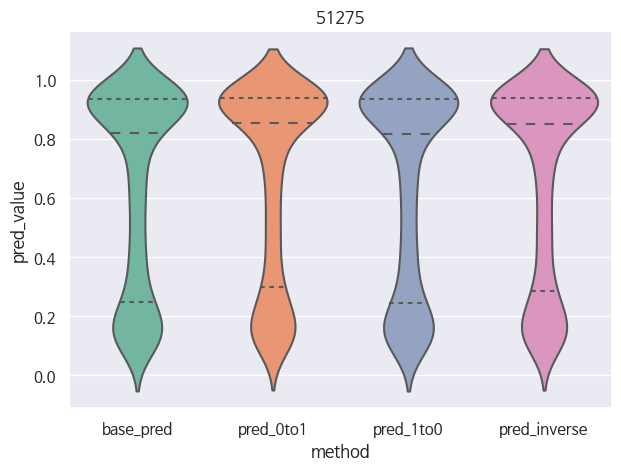

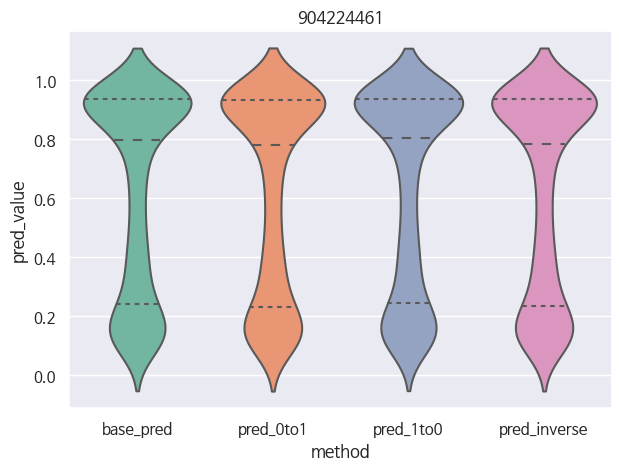

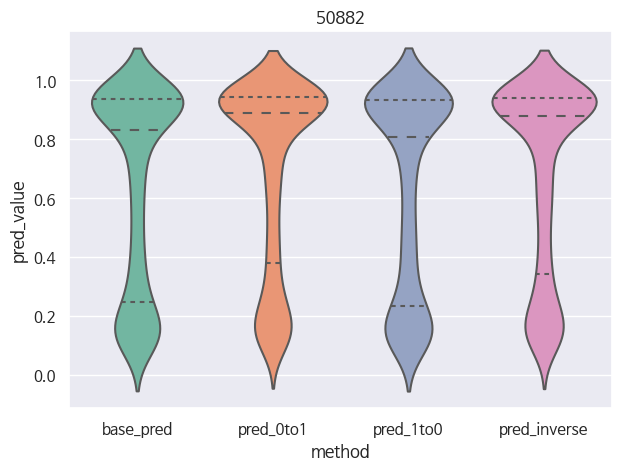

In [170]:
RF_top10 = [51277, 50912, 51006, 63323026201, 50862,
            50983, 51003, 51275, 904224461, 50882]

for i in tqdm(RF_top10):
    FI_merge(i)

## RF bottom10

100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


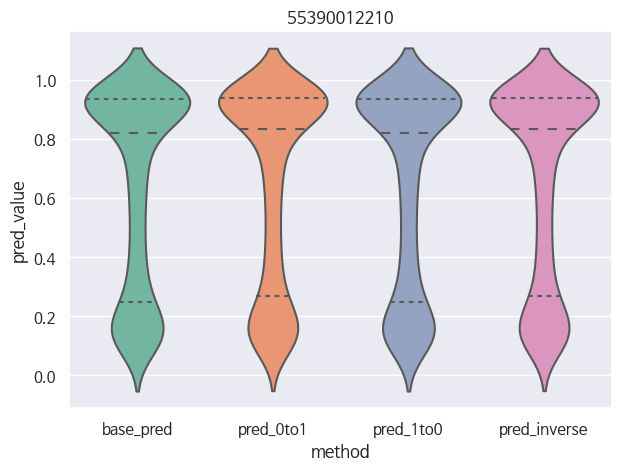

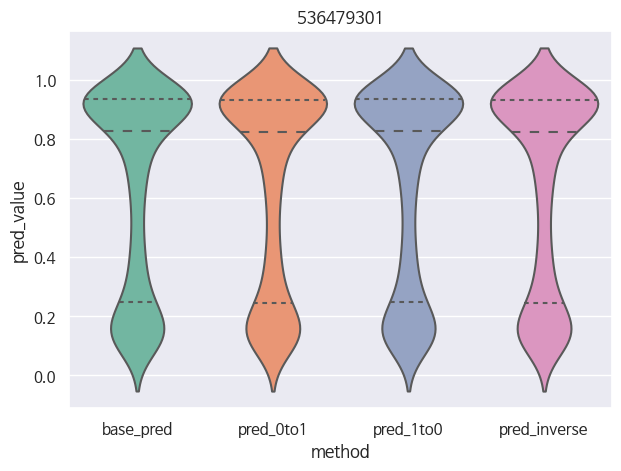

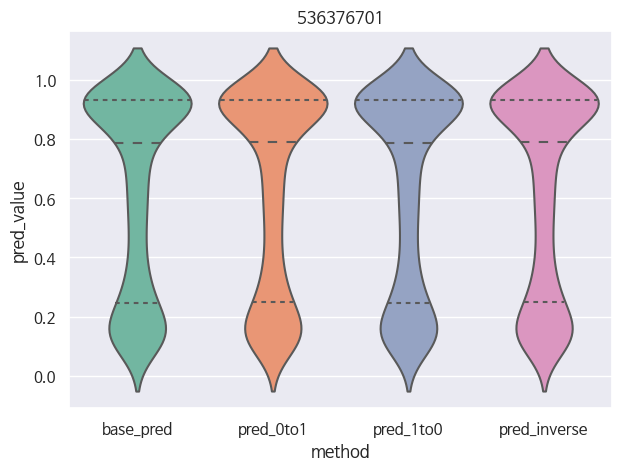

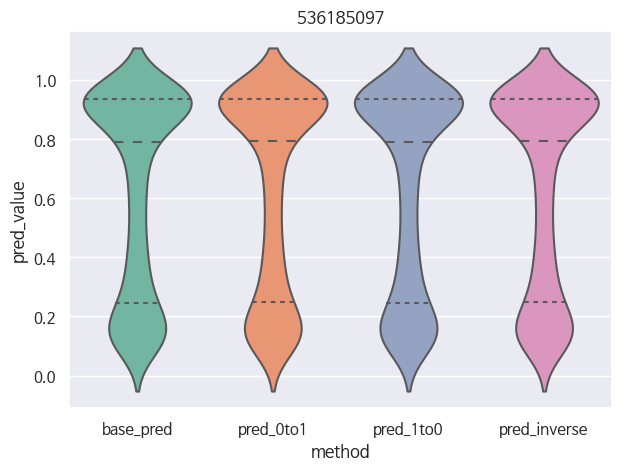

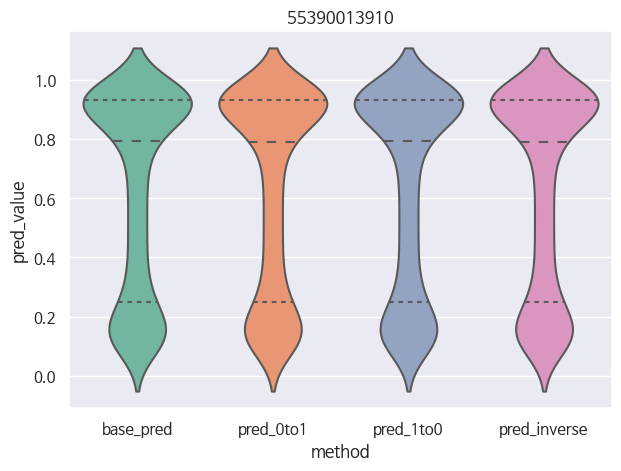

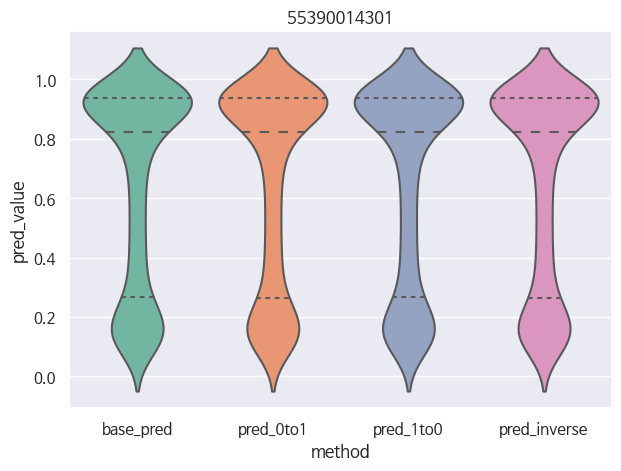

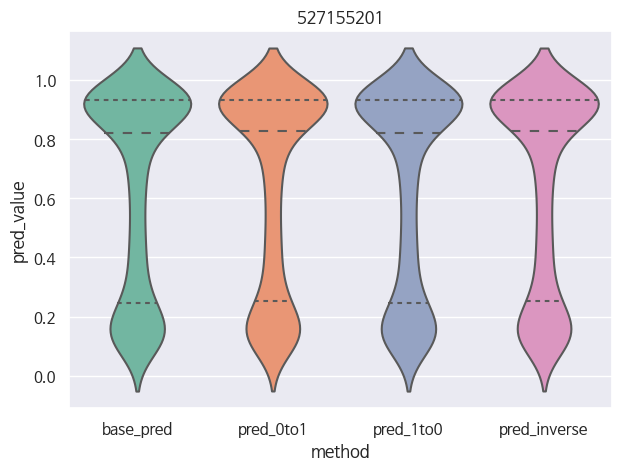

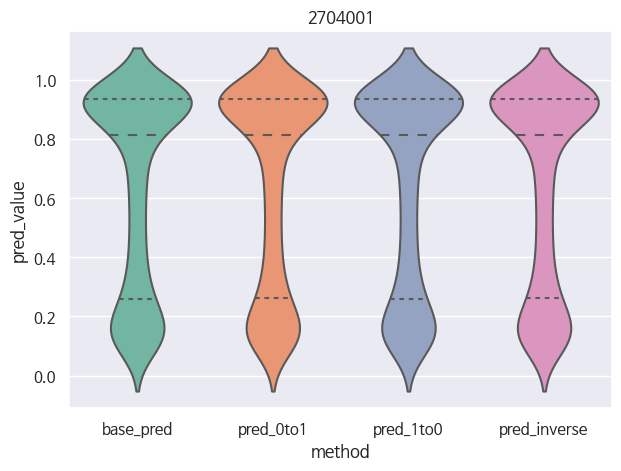

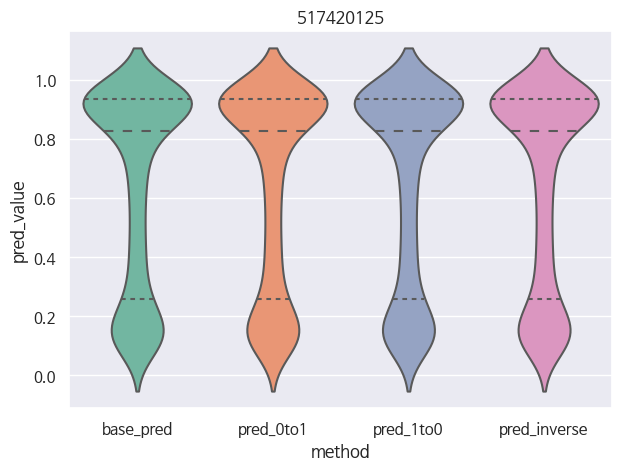

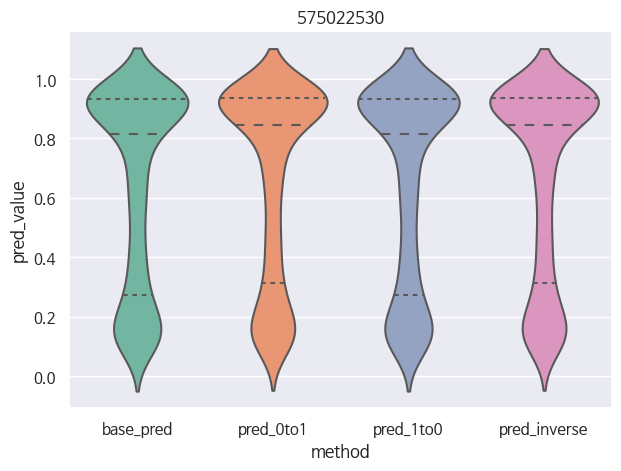

In [171]:
RF_bottom10 = [55390012210, 536479301, 536376701, 536185097, 55390013910,
               55390014301, 527155201, 2704001, 517420125, 575022530]

for i in tqdm(RF_bottom10):
    FI_merge(i)

## M1 entropy top5

100%|██████████| 10/10 [00:49<00:00,  4.98s/it]


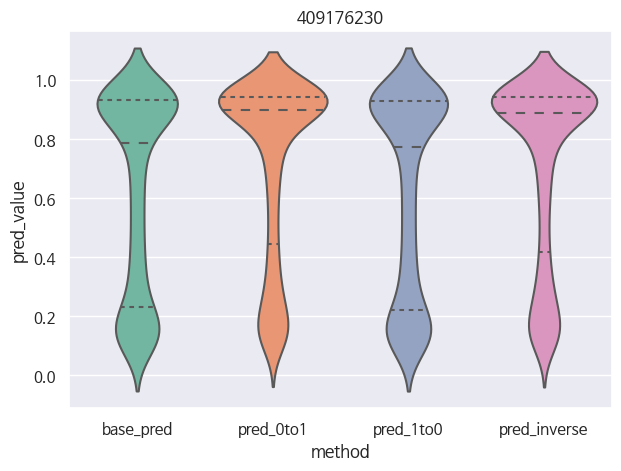

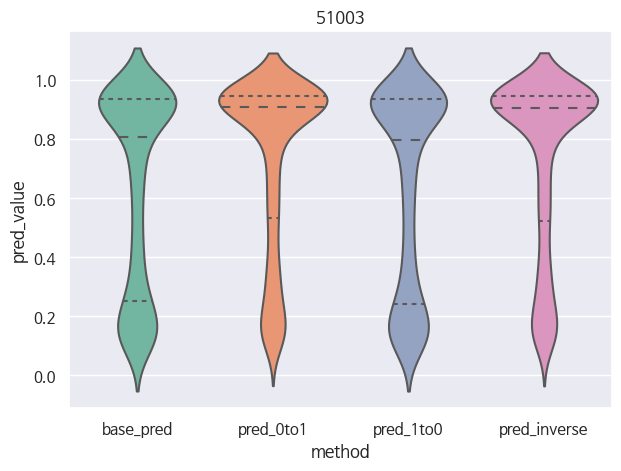

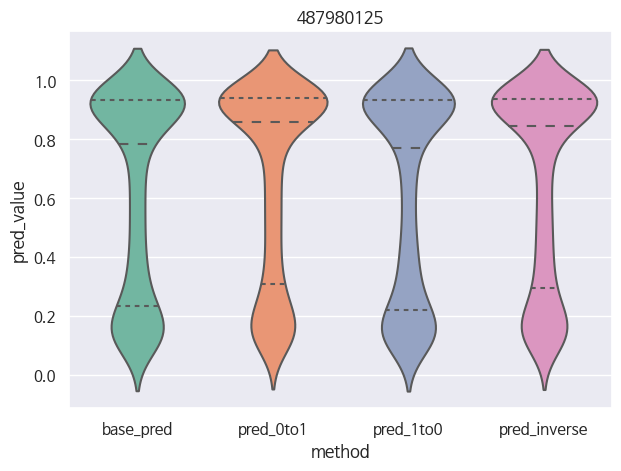

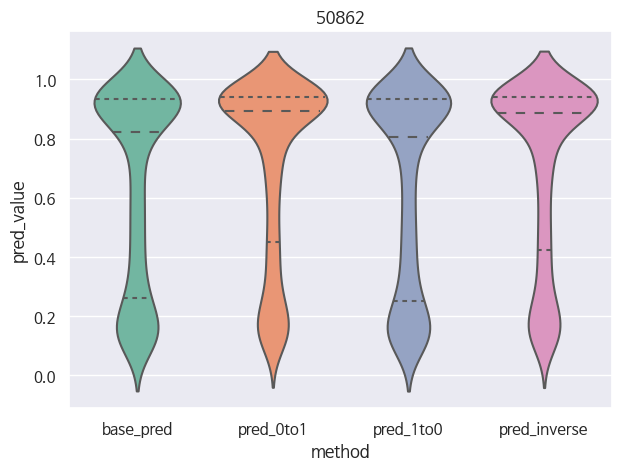

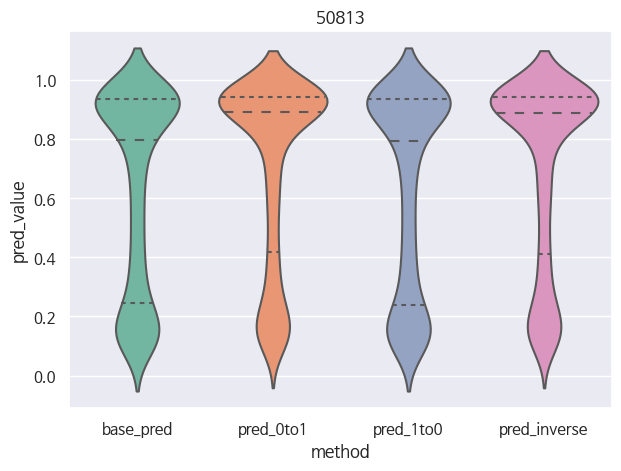

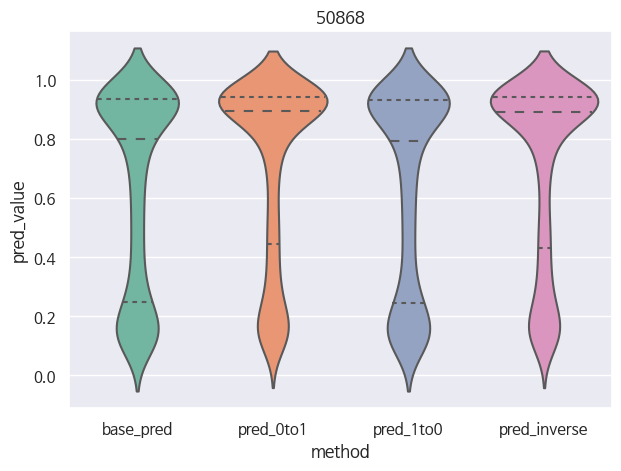

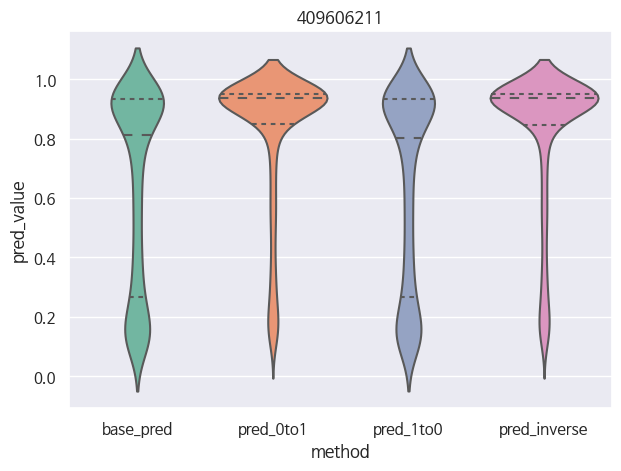

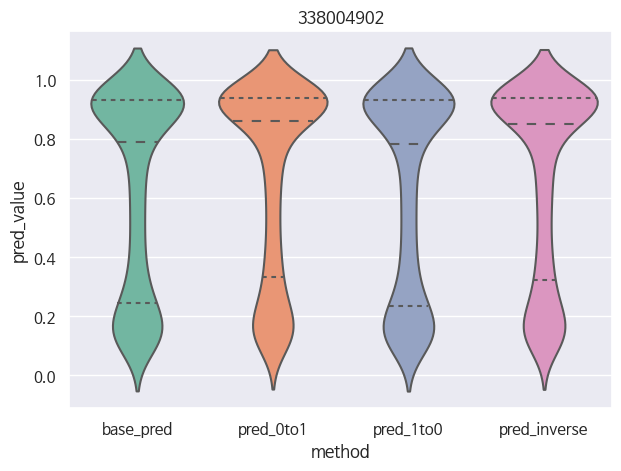

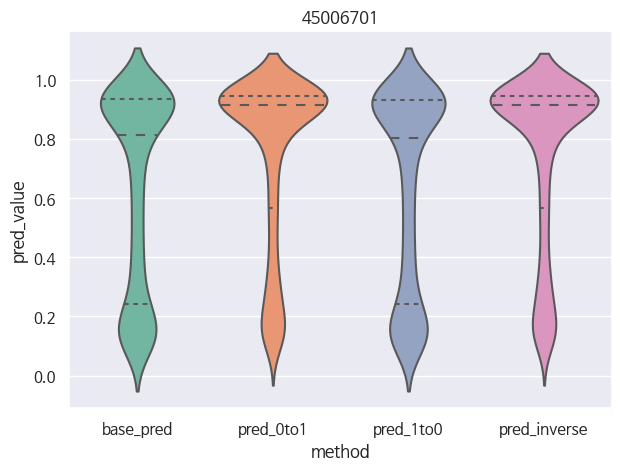

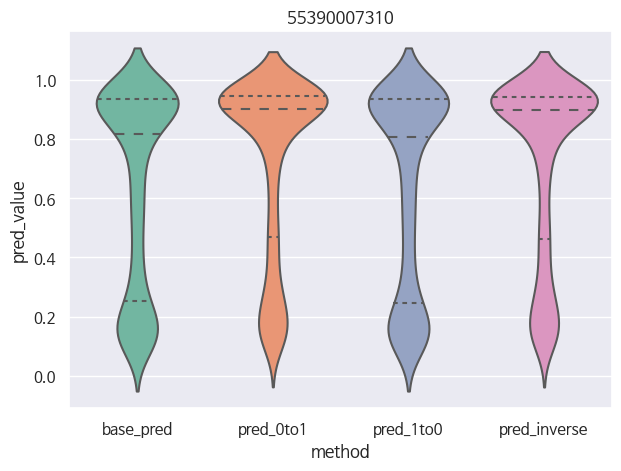

In [172]:
M1_entropy_top5 = [409176230, 51003, 487980125, 50862, 50813,
                   50868, 409606211, 338004902, 45006701, 55390007310]

for i in tqdm(M1_entropy_top5):
    FI_merge(i)

## M1 entropy bottom5

100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


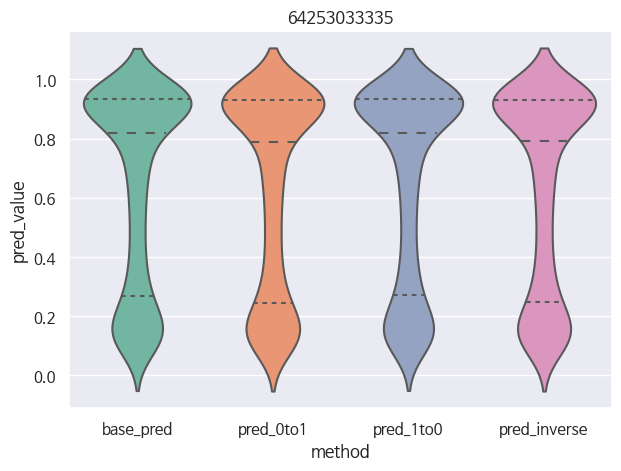

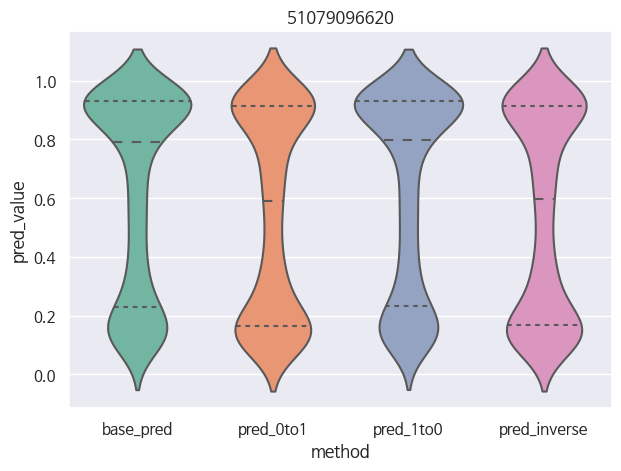

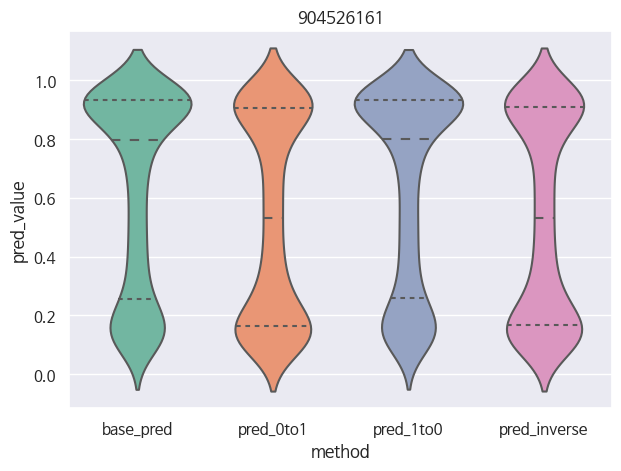

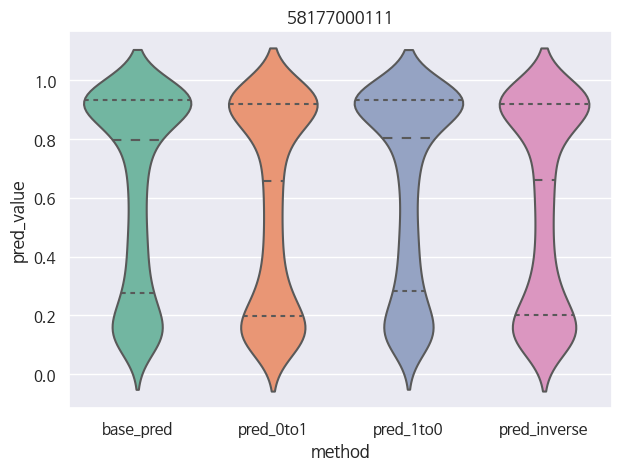

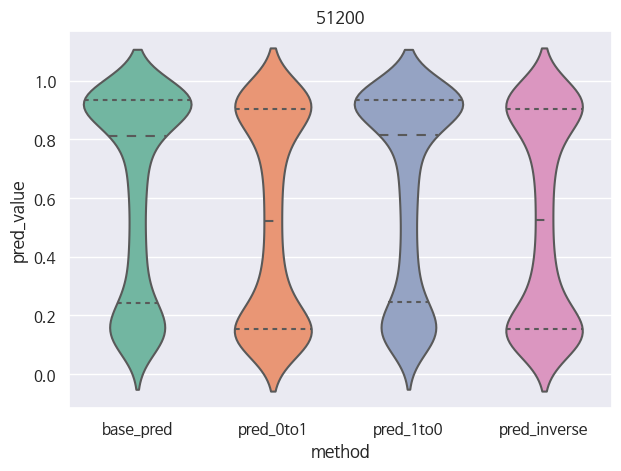

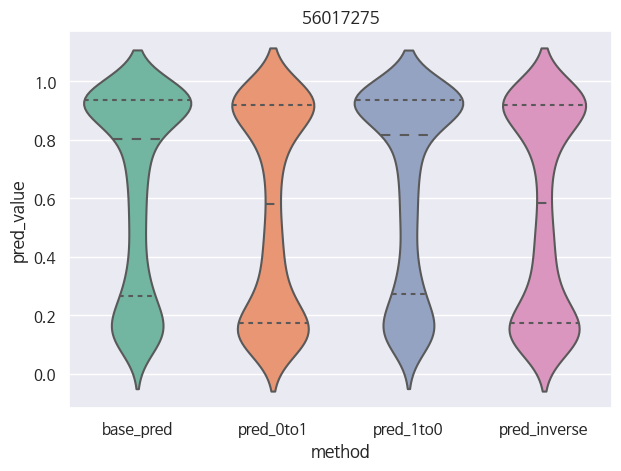

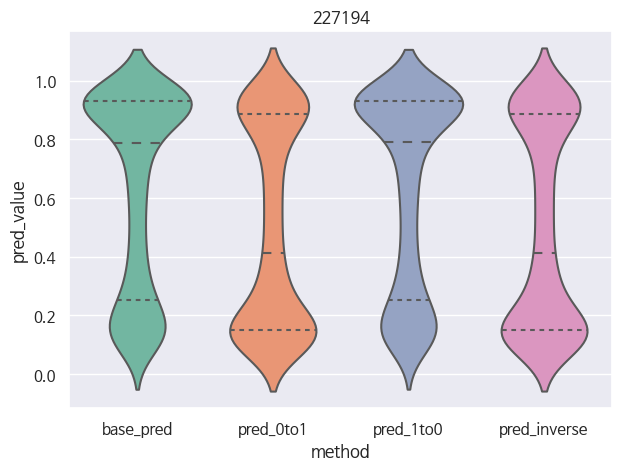

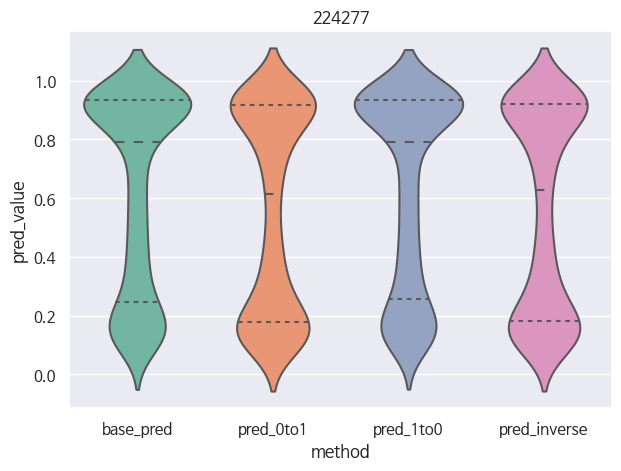

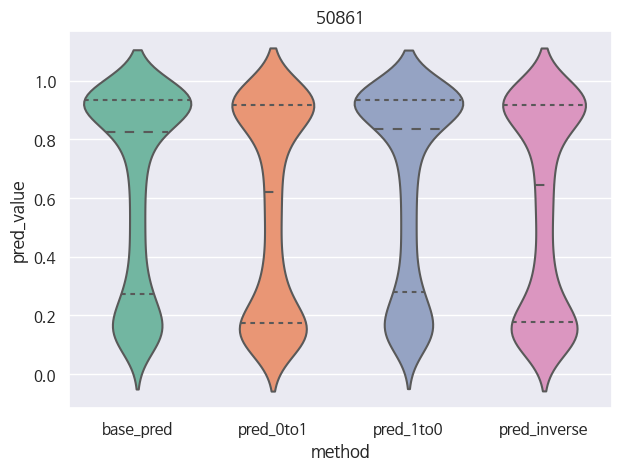

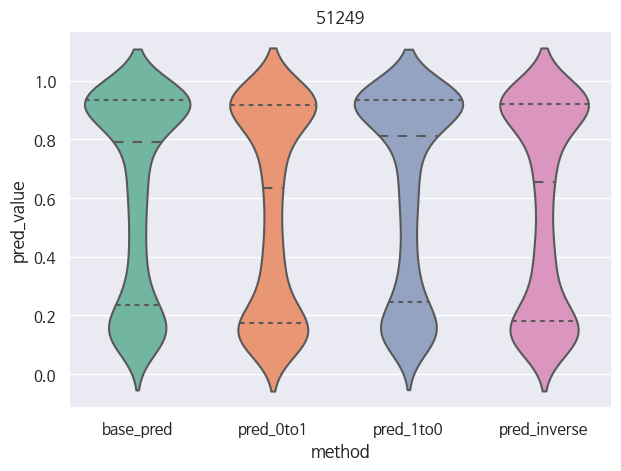

In [173]:
M1_entropy_bottom5 = [64253033335, 51079096620, 904526161, 58177000111, 51200,
                      56017275, 227194, 224277, 50861, 51249]
for i in tqdm(M1_entropy_bottom5):
    FI_merge(i)

## E(0to1) - E(1to0)

In [187]:
mm = pd.read_csv('FI_mean_merge.csv')
mm['E(0to1)-E(1to0)'] = mm['pred_0to1']-mm['pred_1to0']
mm_list = mm.sort_values(by='E(0to1)-E(1to0)',ascending=False)['feature'].values[:10]
mm_list

array([  409606211,    74606211,    67434504, 10019055302,    54817525,
             51277,    54858516,    45006701,    74706811,       51003])

100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


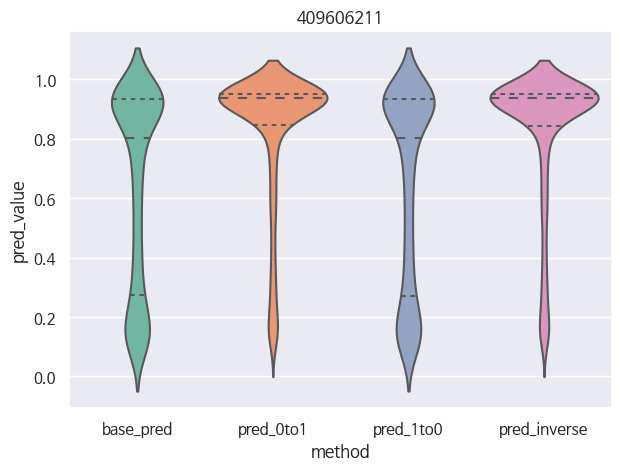

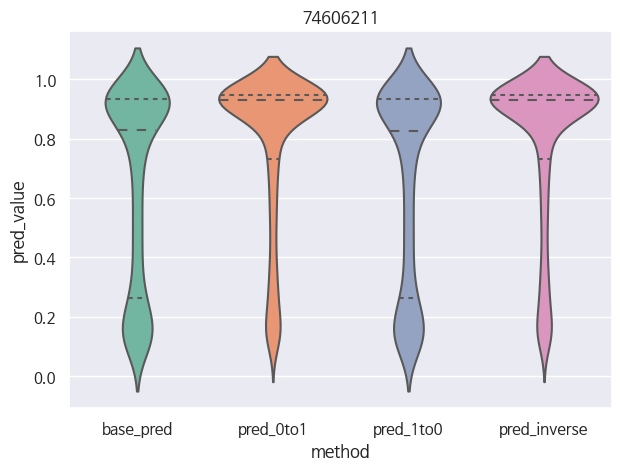

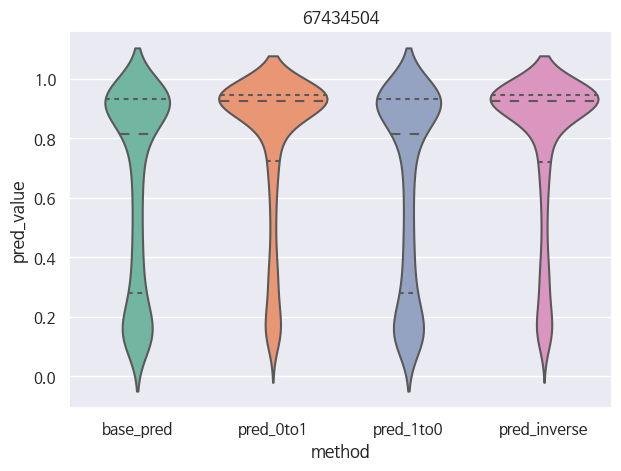

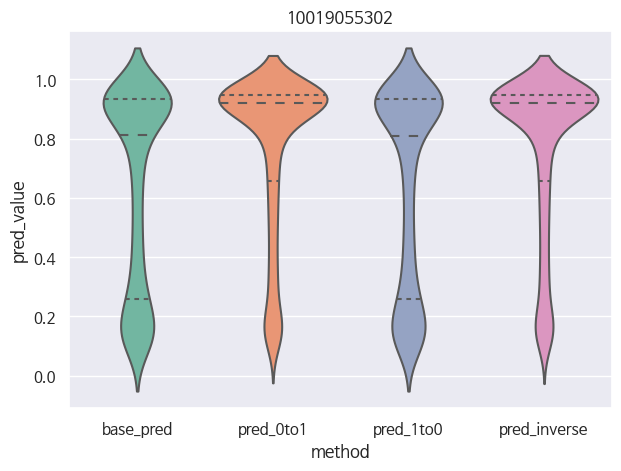

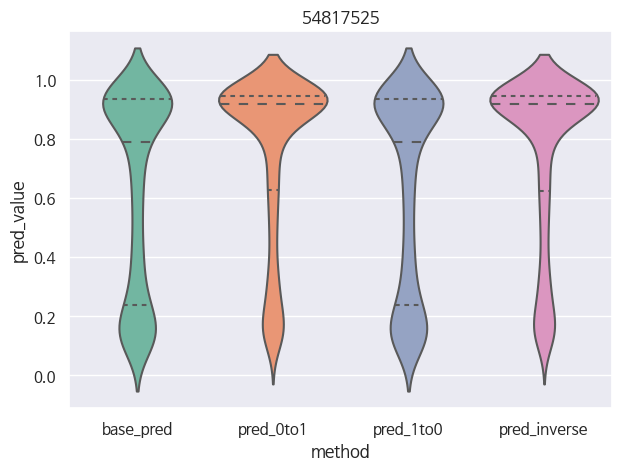

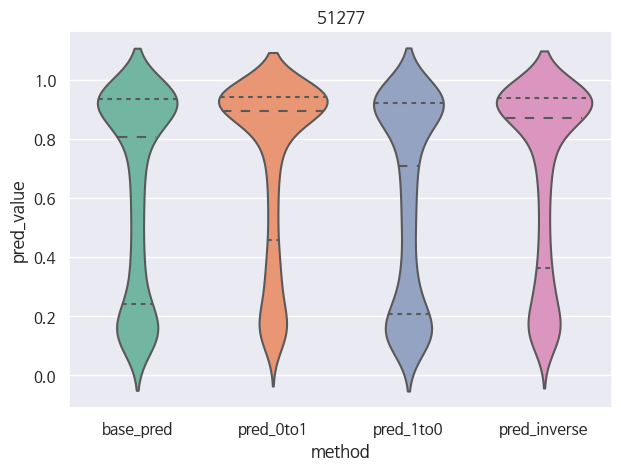

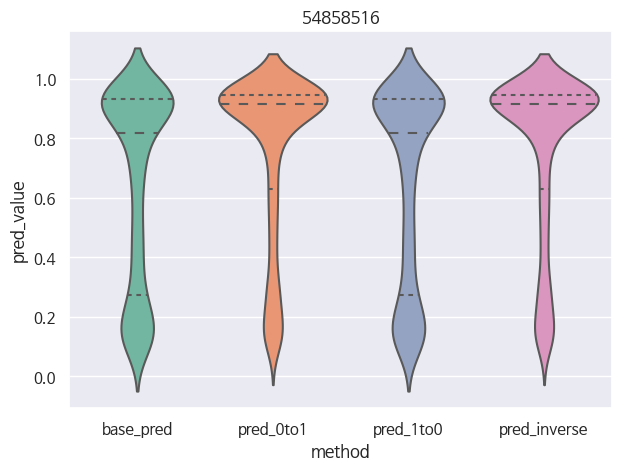

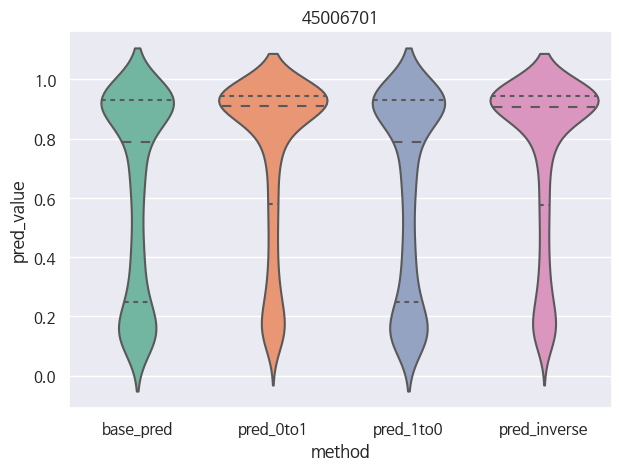

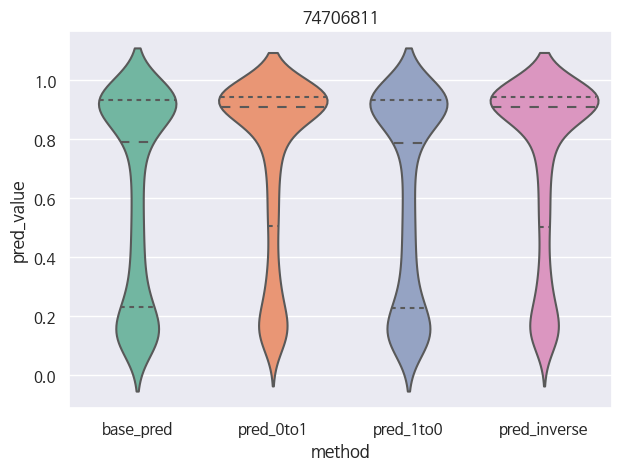

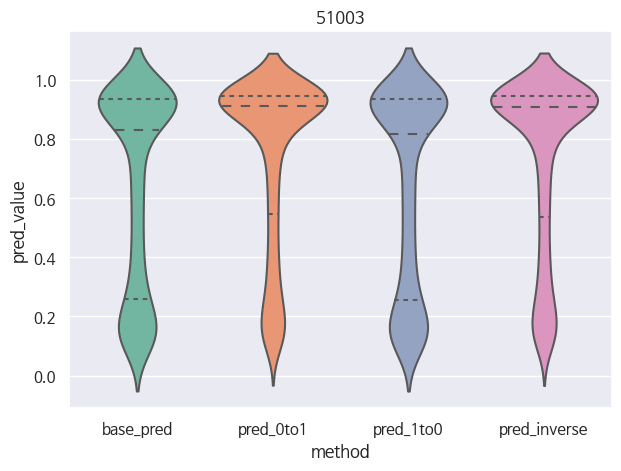

In [191]:
for i in tqdm(list(mm_list)):
    FI_merge(i)